In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
    
import pickle

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *
from src.evaluation import *
from src.regrid import *

In [4]:
DATADRIVE = '/home/jupyter/data/'

In [64]:
# # Using first few days of every month of 2020, eventually use all of 2020
ds_test = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2020-05', '2020-05'),
    scale=False,
    first_days=12,
)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [6]:
ds = xr.open_dataset(
    '/home/jupyter/data/hrrr/raw/total_precipitation/20180215_00.nc')

In [7]:
ds_regridded = regrid(ds, 4, lons=(235, 290), lats=(50, 20))[0]

Creating new regridder


/opt/conda/envs/ilan/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [8]:
hrrr_mask = np.isfinite(ds_regridded).tp.isel(init_time=0, lead_time=0)

In [9]:
rq = xr.open_dataarray(f'{DATADRIVE}/mrms/4km/RadarQuality.nc')
mrms_mask = rq>-1
mrms_mask = mrms_mask.assign_coords({
    'lat': hrrr_mask.lat,
    'lon': hrrr_mask.lon
})

In [10]:
total_mask = mrms_mask * hrrr_mask

In [11]:
# total_mask = total_mask.isel(lat=slice(0, -6))

In [12]:
total_mask = total_mask.assign_coords({'lat': ds_test.mrms.lat.values, 'lon': ds_test.mrms.lon.values})

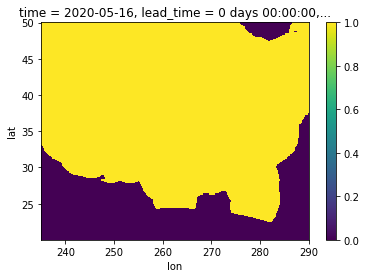

In [13]:
total_mask.plot()

## MRMS

In [65]:
mrms = ds_test.mrms.rename({'time': 'valid_time'}).where(total_mask)

In [66]:
mrms = mrms.isel(valid_time=slice(2, None))

## HRRR baseline

In [67]:
fn = f'{DATADRIVE}/hrrr/4km/total_precipitation/202005*.nc'
hrrr = xr.open_mfdataset(fn)

In [68]:
hrrr = hrrr.tp.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))

In [69]:
hrrr['valid_time'] = hrrr.init_time + hrrr.lead_time
hrrr = hrrr.swap_dims({'init_time': 'valid_time'})

In [70]:
hrrr = hrrr.assign_coords({'lat': mrms.lat.values, 'lon': mrms.lon.values})

In [71]:
hrrr = hrrr.sel(valid_time=mrms.valid_time).where(total_mask)

In [72]:
hrrr

<xarray.DataArray 'tp' (valid_time: 21, lat: 750, lon: 1376)>
dask.array<where, shape=(21, 750, 1376), dtype=float32, chunksize=(1, 750, 1376), chunktype=numpy.ndarray>
Coordinates:
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * valid_time  (valid_time) datetime64[ns] 2020-05-02T12:00:00 ... 2020-05-1...
    time        datetime64[ns] 2020-05-16

In [73]:
hrrr.load();

## HREF baseline

In [74]:
href = xr.open_mfdataset('/home/jupyter/data/hrefv2//4km/total_precipitation/202005*.nc')

In [75]:
href = href.tp.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))

In [76]:
href['valid_time'] = href.init_time + href.lead_time
href = href.swap_dims({'init_time': 'valid_time'})

In [77]:
href = href.assign_coords({'lat': mrms.lat.values, 'lon': mrms.lon.values})

In [78]:
href = href.sel(valid_time=mrms.valid_time).where(total_mask)

In [79]:
href

,Array,Chunk
Bytes,826.72 MiB,39.37 MiB
Shape,"(10, 21, 750, 1376)","(10, 1, 750, 1376)"
Count,477 Tasks,21 Chunks
Type,float32,numpy.ndarray


In [80]:
href.load();

## Load intermediate arrays

In [81]:
# mrms = xr.open_dataarray('../tmp/mrms.nc').load()
# hrrr = xr.open_dataarray('../tmp/hrrr.nc').load()
# href = xr.open_dataarray('../tmp/href.nc').load()

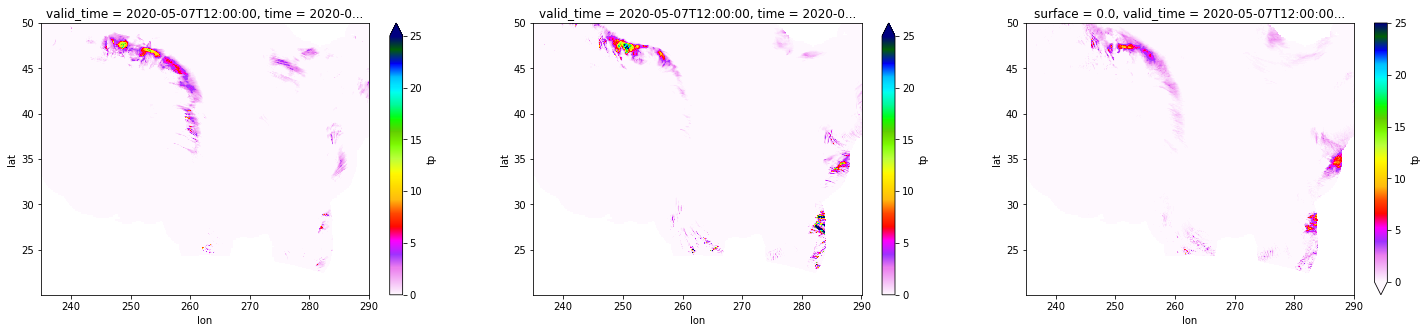

In [82]:
time = 10
vmax=25
valid_time = mrms.valid_time.isel(valid_time=time)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
mrms.sel(valid_time=valid_time).plot(ax=ax1, vmin=0, vmax=vmax, cmap='gist_ncar_r')
hrrr.sel(valid_time=valid_time).plot(ax=ax2, vmin=0, vmax=vmax, cmap='gist_ncar_r')
href.mean('member').sel(valid_time=valid_time).plot(ax=ax3, vmin=0, vmax=vmax, cmap='gist_ncar_r')

## Make my own HRRR ensemble

In [112]:
hrrr.roll(lat=2)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/dataarray.py:3223: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = self._to_temp_dataset().roll(


<xarray.DataArray 'tp' (valid_time: 21, lat: 750, lon: 1376)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [ 3.5615343e-01,  5.7663363e-01,  7.6697707e-01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [ 6.0617387e-01,  1.2592814e+00,  2.0477579e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [ 2.6628637e+00,  4.9146876e+00,  7.1907907e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 20.08 20.04 50.0 49.96 ... 20.24 20.2 20.16 20.12
  * valid_time  (valid_time) datetime64[ns] 2020-05-02T12:00:00 ... 2020-05-1...
    time        datetime64[ns] 2020-05-16

In [113]:
hrrr.roll(lat=-2)

<xarray.DataArray 'tp' (valid_time: 21, lat: 750, lon: 1376)>
array([[[ 1.7895937e+00,  1.4516767e+00,  1.0956554e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.8870108e+00,  1.3639398e+00,  8.6028498e-01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.7212085e+00,  9.8564184e-01,  4.9655166e-01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [ 3.5615343e-01,  5.7663363e-01,  7.6697707e-01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.3335133e+00,  1.1721808e+00,  9.8824507e-01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 2.6505585e+00,  2.9574444e+00,  3.0092430e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 3.3690696e+00,  3.7423859e+00,  3.4678254e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 3.5751448e+00,  3.7205086e+00,  3.3878655e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 1.9098370e+01,  1.9722061e+01,  1.9922104e+01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 2.4285259e+01,  2.3277506e+01,  2.0224735e+01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.8243053e+01,  1.4945894e+01,  1.1618065e+01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [ 2.6628637e+00,  4.9146876e+00,  7.1907907e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 1.1053519e+01,  1.1943108e+01,  1.2856972e+01, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]], dtype=float32)
Coordinates:
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 49.92 49.88 49.84 49.8 ... 20.08 20.04 50.0 49.96
  * valid_time  (valid_time) datetime64[ns] 2020-05-02T12:00:00 ... 2020-05-1...
    time        datetime64[ns] 2020-05-16

In [132]:
hrrr2 = xr.concat([
    hrrr.roll(lat=5, roll_coords=False),
    hrrr.roll(lat=-5, roll_coords=False),
    hrrr.roll(lon=5, roll_coords=False),
    hrrr.roll(lon=-5, roll_coords=False),
    hrrr.roll(lat=5, lon=5, roll_coords=False),
    hrrr.roll(lat=5, lon=-5, roll_coords=False),
    hrrr.roll(lat=-5, lon=5, roll_coords=False),
    hrrr.roll(lat=-5, lon=-5, roll_coords=False),
    hrrr,
    hrrr.roll(lat=1, roll_coords=False),
], 'member')

## Compute scores

In [134]:
threshold = 20
prob_threshold = 0.1
mrms_thresh = mrms > threshold
hrrr_thresh = hrrr > threshold
href_thresh = (href > threshold).mean('member') > prob_threshold
hrrr2_thresh = (hrrr2 > threshold).mean('member') > prob_threshold

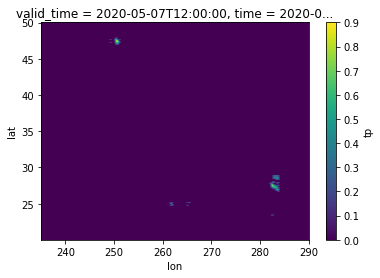

In [135]:
(hrrr2 > threshold).mean('member').isel(valid_time=10).plot()

In [128]:
def compute_csi(o, f, dims=['valid_time', 'lat', 'lon']):
    tp = o * f
    fp = ~o * f
    fn = ~f * o
    csi = tp.sum(dims) / (tp.sum(dims) + fn.sum(dims) + fp.sum(dims))
    return csi

In [95]:
compute_csi(mrms_thresh, hrrr_thresh)

<xarray.DataArray 'tp' ()>
array(0.07553474)
Coordinates:
    time       datetime64[ns] 2020-05-16
    lead_time  timedelta64[ns] 00:00:00
    init_time  datetime64[ns] 2018-02-15

In [96]:
compute_csi(mrms_thresh, href > threshold)

<xarray.DataArray 'tp' (member: 10)>
array([0.07846283, 0.07198334, 0.04579808, 0.01604332, 0.11738431,
       0.0731162 , 0.06135195, 0.04238916, 0.07553474, 0.05561121])
Coordinates:
    time       datetime64[ns] 2020-05-16
    lead_time  timedelta64[ns] 00:00:00
    init_time  datetime64[ns] 2018-02-15
    surface    float64 0.0
  * member     (member) object 'hiresw_conusarw' ... 'hrrr-12h'

In [136]:
compute_csi(mrms_thresh, hrrr2 > threshold)

<xarray.DataArray 'tp' (member: 10)>
array([0.07455277, 0.06596097, 0.07260947, 0.07496682, 0.07367971,
       0.07218197, 0.06605149, 0.06544832, 0.07553474, 0.07528908])
Coordinates:
    time       datetime64[ns] 2020-05-16
    lead_time  timedelta64[ns] 00:00:00
    init_time  datetime64[ns] 2018-02-15
Dimensions without coordinates: member

In [130]:
tmp = (href > threshold).mean('member')

In [98]:
prob_thresholds = np.arange(0, 0.5, 0.1)
o = xr.concat([compute_csi(mrms_thresh, tmp > pt) for pt in prob_thresholds], prob_thresholds)

In [ ]:
a

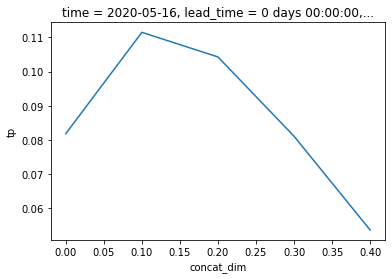

In [99]:
o.plot()

In [100]:
compute_csi(mrms_thresh, href_thresh)

<xarray.DataArray 'tp' ()>
array(0.11146652)
Coordinates:
    time       datetime64[ns] 2020-05-16
    lead_time  timedelta64[ns] 00:00:00
    init_time  datetime64[ns] 2018-02-15
    surface    float64 0.0

In [137]:
compute_csi(mrms_thresh, hrrr2_thresh)

<xarray.DataArray 'tp' ()>
array(0.08755607)
Coordinates:
    time       datetime64[ns] 2020-05-16
    lead_time  timedelta64[ns] 00:00:00
    init_time  datetime64[ns] 2018-02-15

In [62]:
edges = np.array([-np.inf, 5, np.inf])
cont_hrrr = xs.Contingency(mrms.chunk({'valid_time': 10}), hrrr.chunk({'valid_time': 10}), edges, edges, dim=['valid_time', 'lat', 'lon'])

In [63]:
cont_hrrr.threat_score().values

array(0.40732654)

## Debug HREF

In [74]:
href

<xarray.DataArray 'tp' (member: 10, valid_time: 108, lat: 750, lon: 1376)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[ 2.00601816e+00,  2.00601816e+00,  2.00601816e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.64872050e+00,  2.07739806e+00,  2.00601816e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.44356441e+00,  3.17890978e+00,  2.89573479e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           5.66494823e-01,  2.96952367e-01,  1.26129150e-01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           3.26510429e-01,  2.67808676e-01,  2.60011911e-01],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           1.82678461e-01,  1.94554806e-01,  2.18770266e-01],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]],
      dtype=float32)
Coordinates:
    surface     float64 0.0
  * valid_time  (valid_time) datetime64[ns] 2020-01-02T12:00:00 ... 2020-12-0...
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * member      (member) object 'hiresw_conusarw' ... 'hrrr-12h'
    variable    <U2 'tp'

### HREF Full

In [17]:
href = xr.open_mfdataset('/home/jupyter/data//href/4km/total_precipitation/2020010*.nc')

In [18]:
href.load();

In [19]:
href

<xarray.Dataset>
Dimensions:     (init_time: 17, lat: 750, lead_time: 9, lon: 1376, member: 10)
Coordinates:
  * lead_time   (lead_time) timedelta64[ns] 0 days 00:00:00 ... 2 days 00:00:00
    time        (init_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-09...
    surface     float64 0.0
    valid_time  (init_time, lead_time) datetime64[ns] 2020-01-01T12:00:00 ......
  * init_time   (init_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-09...
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * member      (member) object 'hiresw_conusarw' ... 'hrrr-12h'
Data variables:
    tp          (member, init_time, lat, lon, lead_time) float32 0.0 0.0 ... nan

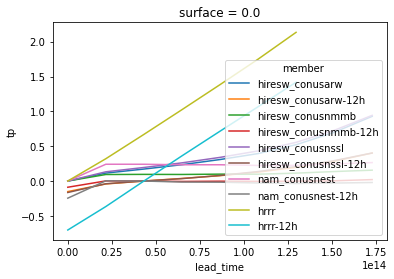

In [20]:
href.tp.mean(('init_time', 'lat', 'lon')).plot(hue='member')

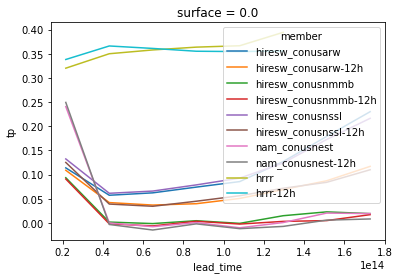

In [21]:
href.tp.diff('lead_time').mean(('init_time', 'lat', 'lon')).plot(hue='member')

In [54]:
hdiff = href.tp.diff('lead_time')

In [57]:
hdiff = hdiff.assign_coords({'lat': mrms.lat.values, 'lon': mrms.lon.values})

In [58]:
hdiff = hdiff.where(total_mask)

In [60]:
vmax=25

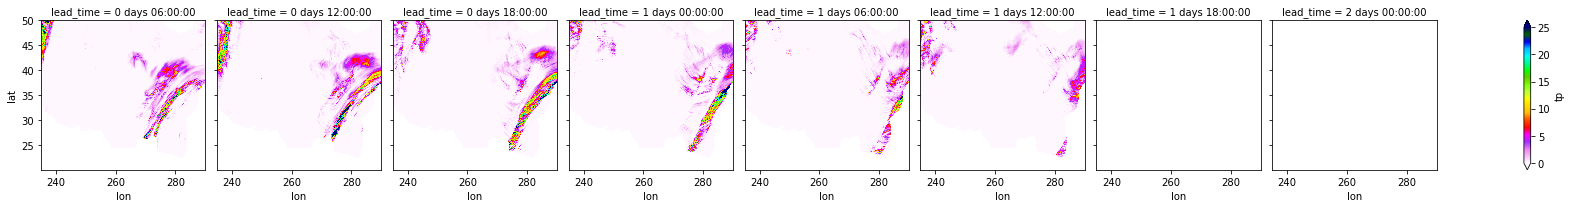

In [92]:
hdiff.sel(member='hrrr', init_time='2020-01-04T00').plot(
    vmin=0, vmax=vmax, cmap='gist_ncar_r', col='lead_time'
)

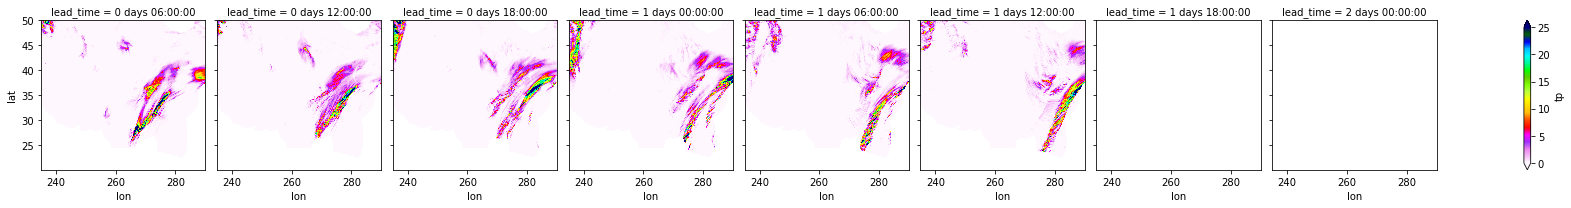

In [93]:
hdiff.sel(member='hrrr-12h', init_time='2020-01-04T00').plot(
    vmin=0, vmax=vmax, cmap='gist_ncar_r', col='lead_time'
)

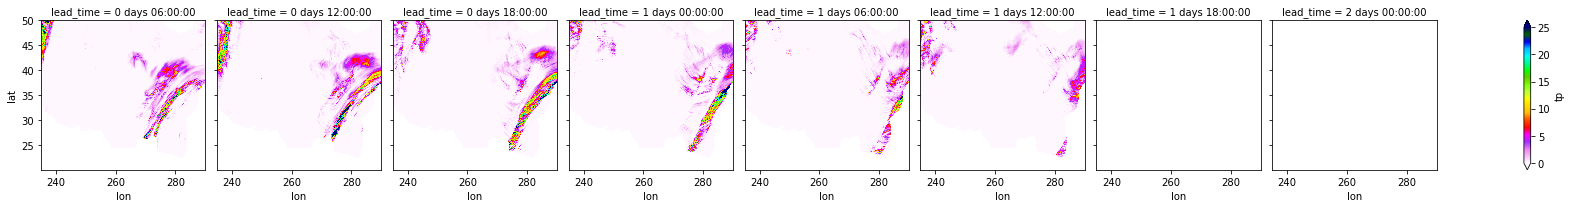

In [94]:
hdiff.sel(member='hrrr-12h', init_time='2020-01-04T12').plot(
    vmin=0, vmax=vmax, cmap='gist_ncar_r', col='lead_time'
)

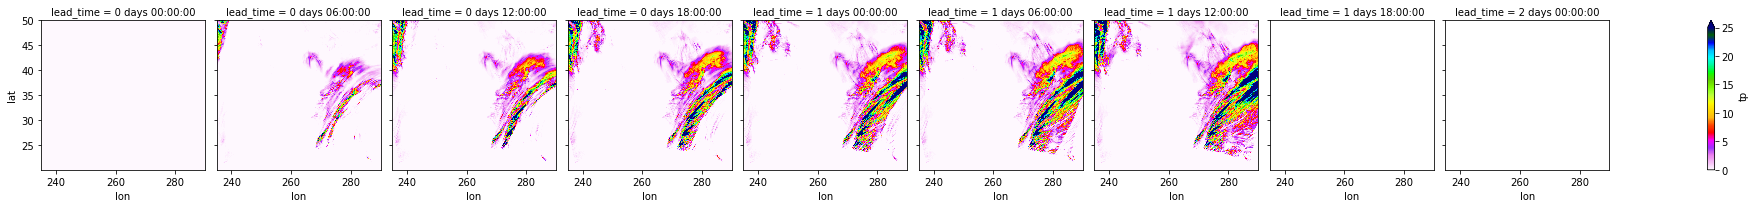

In [95]:
href.tp.sel(member='hrrr', init_time='2020-01-04T00').plot(
    vmin=0, vmax=vmax, cmap='gist_ncar_r', col='lead_time'
)

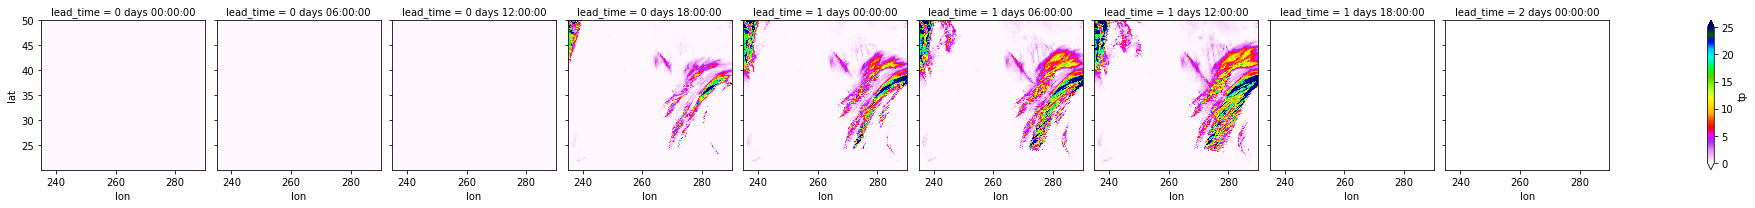

In [96]:
href.tp.sel(member='hrrr-12h', init_time='2020-01-04T00').plot(
    vmin=0, vmax=vmax, cmap='gist_ncar_r', col='lead_time'
)

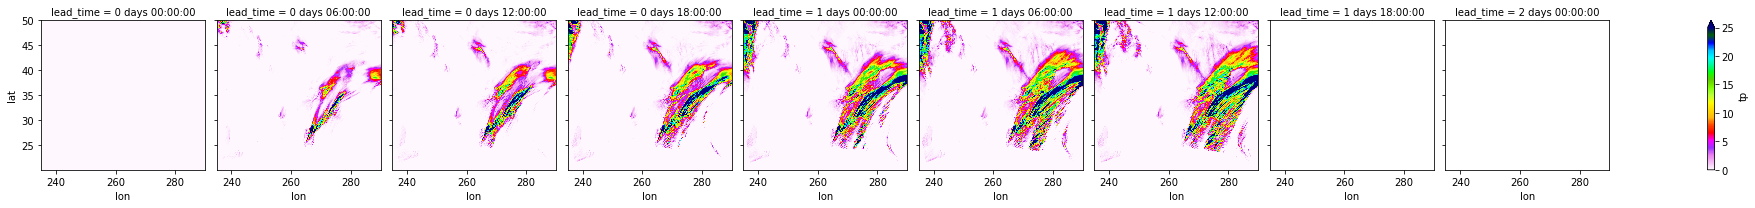

In [99]:
href.tp.sel(member='hrrr', init_time='2020-01-03T12').plot(
    vmin=0, vmax=vmax, cmap='gist_ncar_r', col='lead_time'
)

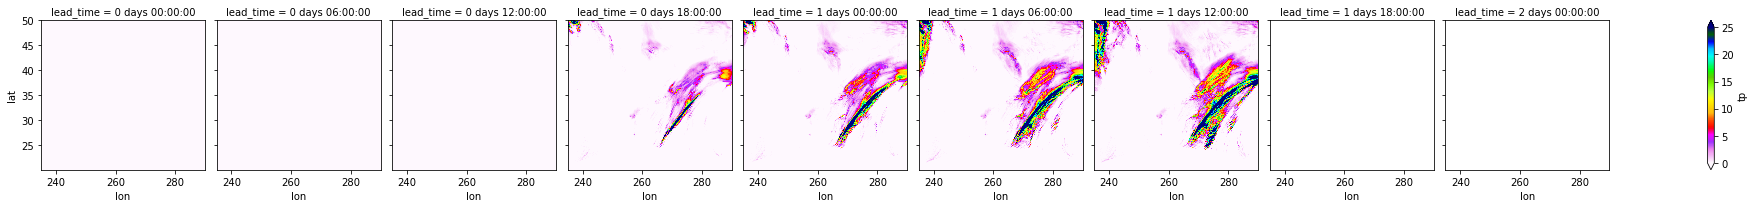

In [98]:
href.tp.sel(member='hrrr-12h', init_time='2020-01-03T12').plot(
    vmin=0, vmax=vmax, cmap='gist_ncar_r', col='lead_time'
)

In [103]:
current = href.tp.sel(member='hrrr')

In [135]:
previous = href.tp.sel(member='hrrr')

In [136]:
lag = 12

In [137]:
previous = previous.sel(lead_time=slice(np.timedelta64(lag, 'h'), None))
previous = previous.assign_coords({
                        'init_time': previous.init_time + np.timedelta64(lag, 'h')}).assign_coords({
                        'lead_time': previous.lead_time - np.timedelta64(lag, 'h')
                    }).assign_coords({'member': 'hrrr-12h'})

In [108]:
current

<xarray.DataArray 'tp' (init_time: 17, lat: 750, lon: 1376, lead_time: 9)>
array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          1.9729967e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          3.4007013e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          4.6729650e+00,           nan,           nan],
         ...,
         [0.0000000e+00, 2.5261223e-04, 2.5261223e-04, ...,
          0.0000000e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          5.9546795e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          5.6032119e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          5.2860456e+00,           nan,           nan],
...
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan]]]], dtype=float32)
Coordinates:
  * lead_time   (lead_time) timedelta64[ns] 0 days 00:00:00 ... 2 days 00:00:00
    time        (init_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-09...
    surface     float64 0.0
    valid_time  (init_time, lead_time) datetime64[ns] 2020-01-01T12:00:00 ......
  * init_time   (init_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-09...
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
    member      <U4 'hrrr'

In [138]:
previous

<xarray.DataArray 'tp' (init_time: 17, lat: 750, lon: 1376, lead_time: 7)>
array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          1.9729967e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          3.4007013e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          4.6729650e+00,           nan,           nan],
         ...,
         [2.5261223e-04, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          5.9546795e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          5.6032119e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          5.2860456e+00,           nan,           nan],
...
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00,           nan,           nan]]]], dtype=float32)
Coordinates:
  * lead_time   (lead_time) timedelta64[ns] 00:00:00 ... 1 days 12:00:00
    time        (init_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-09...
    surface     float64 0.0
    valid_time  (init_time, lead_time) datetime64[ns] 2020-01-02 ... 2020-01-...
  * init_time   (init_time) datetime64[ns] 2020-01-02 ... 2020-01-10
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
    member      <U8 'hrrr-12h'

In [139]:
cat = xr.concat([current, previous], dim='member')

In [140]:
cat

<xarray.DataArray 'tp' (member: 2, init_time: 18, lat: 750, lon: 1376, lead_time: 9)>
array([[[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           1.9729967e+00,           nan,           nan],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           3.4007013e+00,           nan,           nan],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           4.6729650e+00,           nan,           nan],
          ...,
          [0.0000000e+00, 2.5261223e-04, 2.5261223e-04, ...,
           0.0000000e+00,           nan,           nan],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00,           nan,           nan],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00,           nan,           nan]],

         [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           5.9546795e+00,           nan,           nan],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           5.6032119e+00,           nan,           nan],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           5.2860456e+00,           nan,           nan],
...
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
                     nan,           nan,           nan],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
                     nan,           nan,           nan],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
                     nan,           nan,           nan]],

         [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
                     nan,           nan,           nan],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
                     nan,           nan,           nan],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
                     nan,           nan,           nan],
          ...,
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
                     nan,           nan,           nan],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
                     nan,           nan,           nan],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
                     nan,           nan,           nan]]]]], dtype=float32)
Coordinates:
  * init_time   (init_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-10
  * lead_time   (lead_time) timedelta64[ns] 0 days 00:00:00 ... 2 days 00:00:00
    time        (member, init_time) datetime64[ns] 2020-01-01T12:00:00 ... 20...
    surface     float64 0.0
    valid_time  (member, init_time, lead_time) datetime64[ns] 2020-01-01T12:0...
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * member      (member) <U8 'hrrr' 'hrrr-12h'

In [141]:
cat_diff = cat.diff('lead_time')

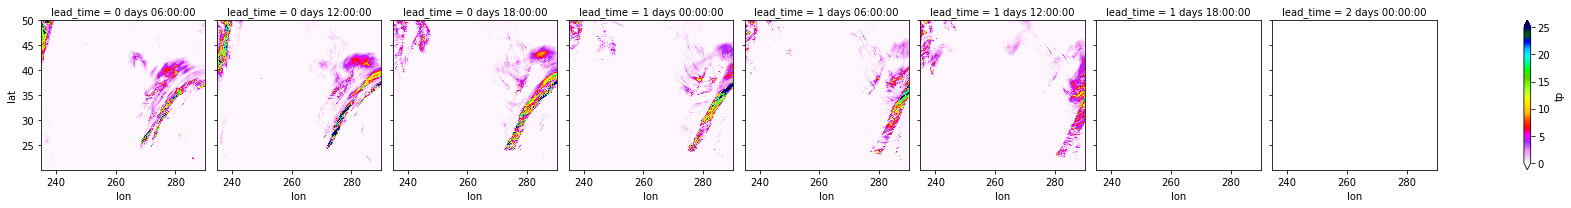

In [142]:
cat_diff.sel(member='hrrr', init_time='2020-01-04T00').plot(
    vmin=0, vmax=vmax, cmap='gist_ncar_r', col='lead_time'
)

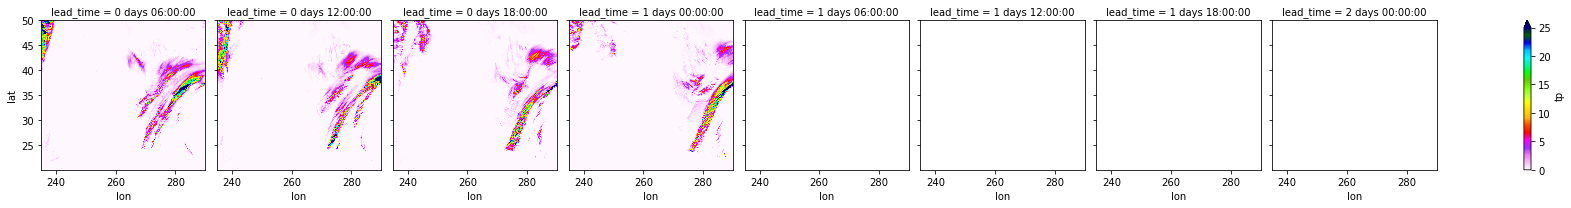

In [143]:
cat_diff.sel(member='hrrr-12h', init_time='2020-01-04T00').plot(
    vmin=0, vmax=vmax, cmap='gist_ncar_r', col='lead_time'
)

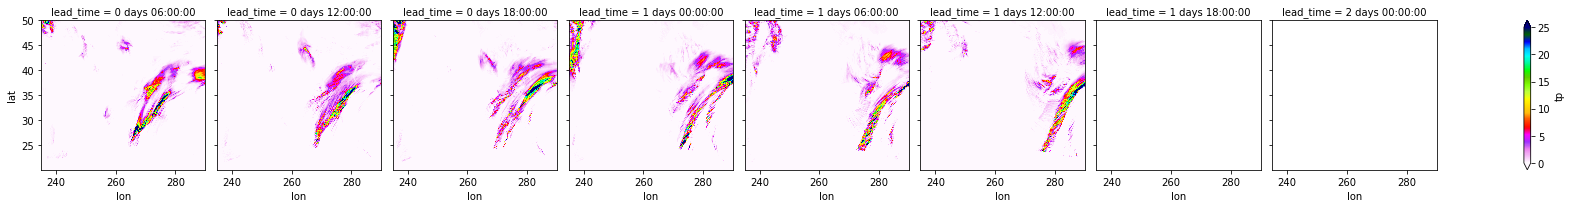

In [145]:
cat_diff.sel(member='hrrr', init_time='2020-01-03T12').plot(
    vmin=0, vmax=vmax, cmap='gist_ncar_r', col='lead_time'
)

In [5]:
new = xr.open_mfdataset('/home/jupyter/data//hrefv2/4km/total_precipitation/2020010*.nc').tp.load()
old = xr.open_mfdataset('/home/jupyter/data//href/4km/total_precipitation/2020010*.nc').tp.load()

In [6]:
new_diff = new.diff('lead_time')
old_diff = old.diff('lead_time')

In [8]:
vmax=25

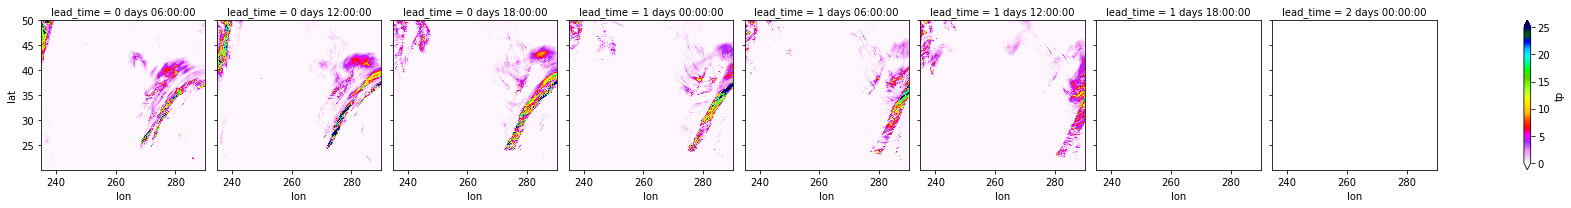

In [9]:
old_diff.sel(member='hrrr', init_time='2020-01-04T00').plot(
    vmin=0, vmax=vmax, cmap='gist_ncar_r', col='lead_time'
)

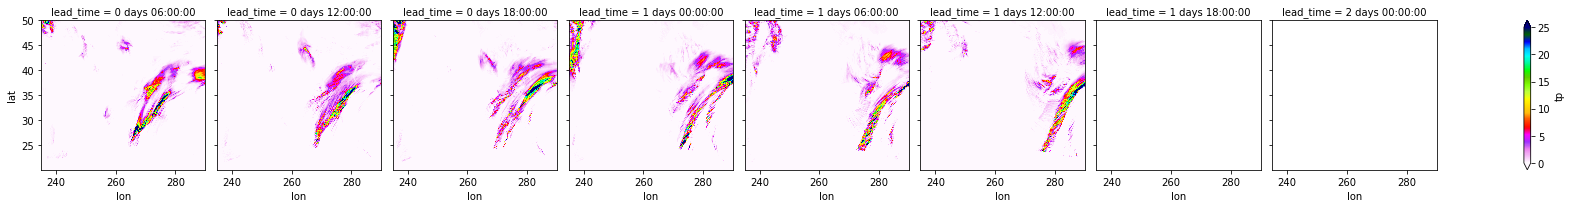

In [10]:
old_diff.sel(member='hrrr-12h', init_time='2020-01-04T00').plot(
    vmin=0, vmax=vmax, cmap='gist_ncar_r', col='lead_time'
)

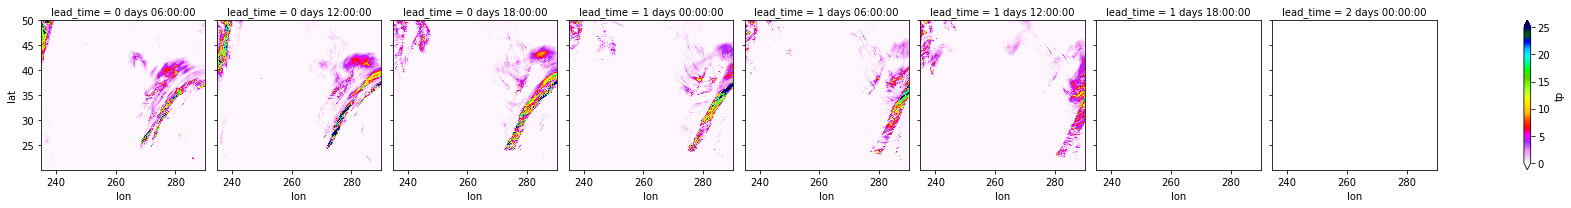

In [11]:
new_diff.sel(member='hrrr', init_time='2020-01-04T00').plot(
    vmin=0, vmax=vmax, cmap='gist_ncar_r', col='lead_time'
)

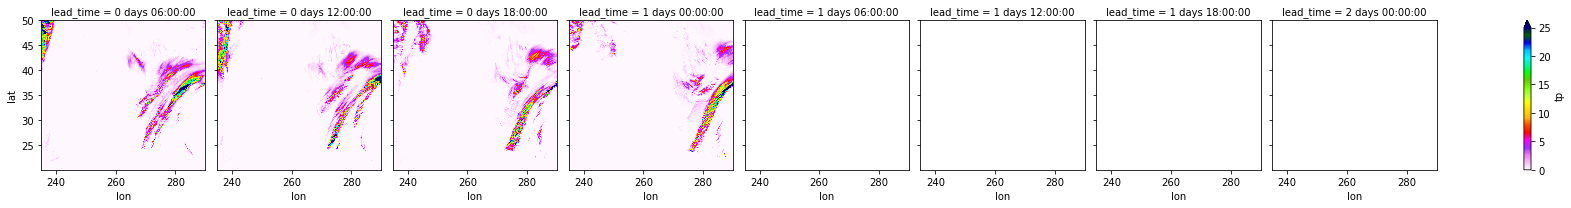

In [12]:
new_diff.sel(member='hrrr-12h', init_time='2020-01-04T00').plot(
    vmin=0, vmax=vmax, cmap='gist_ncar_r', col='lead_time'
)

In [150]:
old

<xarray.DataArray 'tp' (member: 10, init_time: 17, lat: 750, lon: 1376, lead_time: 9)>
dask.array<concatenate, shape=(10, 17, 750, 1376, 9), dtype=float32, chunksize=(10, 1, 750, 1376, 9), chunktype=numpy.ndarray>
Coordinates:
  * lead_time   (lead_time) timedelta64[ns] 0 days 00:00:00 ... 2 days 00:00:00
    time        (init_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-09...
    surface     float64 0.0
    valid_time  (init_time, lead_time) datetime64[ns] dask.array<chunksize=(1, 9), meta=np.ndarray>
  * init_time   (init_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-09...
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * member      (member) object 'hiresw_conusarw' ... 'hrrr-12h'

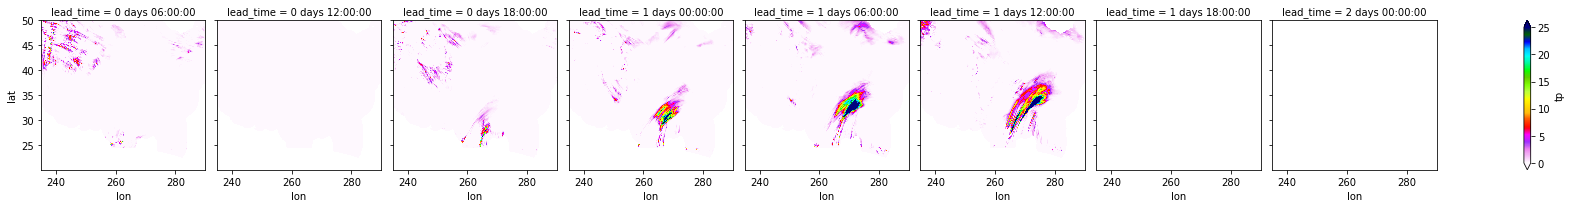

In [83]:
previous.sel(init_time='2020-01-02T12').plot(
    vmin=0, vmax=vmax, cmap='gist_ncar_r', col='lead_time'
)

In [63]:
threshold = 5
prob_threshold = 0.3
mrms_thresh = mrms > threshold
hdiff_thresh = hdiff.sel(member=['hrrr', 'hrrr-12h']) > threshold

In [66]:
mrms_thresh

<xarray.DataArray 'tp' (valid_time: 23, lat: 750, lon: 1376)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-1...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
    time        datetime64[ns] 2020-05-16
    lead_time   timedelta64[ns] 00:00:00
    init_time   datetime64[ns] 2018-02-15

In [67]:
tmp = hdiff_thresh.isel(lead_time=slice(1, None, 2), init_time=slice(1, None))

In [68]:
tmp.valid_time

<xarray.DataArray 'valid_time' (init_time: 16, lead_time: 4)>
array([['2020-01-02T12:00:00.000000000', '2020-01-03T00:00:00.000000000',
        '2020-01-03T12:00:00.000000000', '2020-01-04T00:00:00.000000000'],
       ['2020-01-03T00:00:00.000000000', '2020-01-03T12:00:00.000000000',
        '2020-01-04T00:00:00.000000000', '2020-01-04T12:00:00.000000000'],
       ['2020-01-03T12:00:00.000000000', '2020-01-04T00:00:00.000000000',
        '2020-01-04T12:00:00.000000000', '2020-01-05T00:00:00.000000000'],
       ['2020-01-04T00:00:00.000000000', '2020-01-04T12:00:00.000000000',
        '2020-01-05T00:00:00.000000000', '2020-01-05T12:00:00.000000000'],
       ['2020-01-04T12:00:00.000000000', '2020-01-05T00:00:00.000000000',
        '2020-01-05T12:00:00.000000000', '2020-01-06T00:00:00.000000000'],
       ['2020-01-05T00:00:00.000000000', '2020-01-05T12:00:00.000000000',
        '2020-01-06T00:00:00.000000000', '2020-01-06T12:00:00.000000000'],
       ['2020-01-05T12:00:00.000000000', '2020-01-06T00:00:00.000000000',
        '2020-01-06T12:00:00.000000000', '2020-01-07T00:00:00.000000000'],
       ['2020-01-06T00:00:00.000000000', '2020-01-06T12:00:00.000000000',
        '2020-01-07T00:00:00.000000000', '2020-01-07T12:00:00.000000000'],
       ['2020-01-06T12:00:00.000000000', '2020-01-07T00:00:00.000000000',
        '2020-01-07T12:00:00.000000000', '2020-01-08T00:00:00.000000000'],
       ['2020-01-07T00:00:00.000000000', '2020-01-07T12:00:00.000000000',
        '2020-01-08T00:00:00.000000000', '2020-01-08T12:00:00.000000000'],
       ['2020-01-07T12:00:00.000000000', '2020-01-08T00:00:00.000000000',
        '2020-01-08T12:00:00.000000000', '2020-01-09T00:00:00.000000000'],
       ['2020-01-08T00:00:00.000000000', '2020-01-08T12:00:00.000000000',
        '2020-01-09T00:00:00.000000000', '2020-01-09T12:00:00.000000000'],
       ['2020-01-08T12:00:00.000000000', '2020-01-09T00:00:00.000000000',
        '2020-01-09T12:00:00.000000000', '2020-01-10T00:00:00.000000000'],
       ['2020-01-09T00:00:00.000000000', '2020-01-09T12:00:00.000000000',
        '2020-01-10T00:00:00.000000000', '2020-01-10T12:00:00.000000000'],
       ['2020-01-09T12:00:00.000000000', '2020-01-10T00:00:00.000000000',
        '2020-01-10T12:00:00.000000000', '2020-01-11T00:00:00.000000000'],
       ['2020-01-10T00:00:00.000000000', '2020-01-10T12:00:00.000000000',
        '2020-01-11T00:00:00.000000000', '2020-01-11T12:00:00.000000000']],
      dtype='datetime64[ns]')
Coordinates:
  * lead_time   (lead_time) timedelta64[ns] 0 days 12:00:00 ... 2 days 00:00:00
    surface     float64 0.0
    valid_time  (init_time, lead_time) datetime64[ns] 2020-01-02T12:00:00 ......
  * init_time   (init_time) datetime64[ns] 2020-01-02 ... 2020-01-09T12:00:00

In [69]:
mrms_thresh.valid_time

<xarray.DataArray 'valid_time' (valid_time: 23)>
array(['2020-01-01T12:00:00.000000000', '2020-01-02T00:00:00.000000000',
       '2020-01-02T12:00:00.000000000', '2020-01-03T00:00:00.000000000',
       '2020-01-03T12:00:00.000000000', '2020-01-04T00:00:00.000000000',
       '2020-01-04T12:00:00.000000000', '2020-01-05T00:00:00.000000000',
       '2020-01-05T12:00:00.000000000', '2020-01-06T00:00:00.000000000',
       '2020-01-06T12:00:00.000000000', '2020-01-07T00:00:00.000000000',
       '2020-01-07T12:00:00.000000000', '2020-01-08T00:00:00.000000000',
       '2020-01-08T12:00:00.000000000', '2020-01-09T00:00:00.000000000',
       '2020-01-09T12:00:00.000000000', '2020-01-10T00:00:00.000000000',
       '2020-01-10T12:00:00.000000000', '2020-01-11T00:00:00.000000000',
       '2020-01-11T12:00:00.000000000', '2020-01-12T00:00:00.000000000',
       '2020-01-12T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-1...
    time        datetime64[ns] 2020-05-16
    lead_time   timedelta64[ns] 00:00:00
    init_time   datetime64[ns] 2018-02-15
Attributes:
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

In [71]:
o = compute_csi(mrms_thresh.drop(('init_time', 'lead_time')).sel(valid_time=tmp.valid_time), tmp,
            dims=['init_time', 'lat', 'lon'])

In [73]:
o.lead_time

<xarray.DataArray 'lead_time' (lead_time: 4)>
array([ 43200000000000,  86400000000000, 129600000000000, 172800000000000],
      dtype='timedelta64[ns]')
Coordinates:
    time       datetime64[ns] 2020-05-16
  * lead_time  (lead_time) timedelta64[ns] 0 days 12:00:00 ... 2 days 00:00:00
    surface    float64 0.0

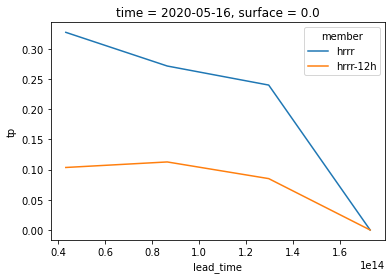

In [72]:
o.plot(hue='member')

In [74]:
hdiff

<xarray.DataArray 'tp' (member: 10, init_time: 17, lat: 750, lon: 1376, lead_time: 8)>
array([[[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            1.58712637e+00, -1.58712637e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            1.27604342e+00, -1.27604342e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            1.00300908e+00, -1.00300908e+00,  0.00000000e+00],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

         [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            2.00601816e+00, -2.00601816e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            2.00601816e+00, -2.00601816e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            1.97021329e+00, -1.97021329e+00,  0.00000000e+00],
...
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]]]]],
      dtype=float32)
Coordinates:
  * lead_time   (lead_time) timedelta64[ns] 0 days 06:00:00 ... 2 days 00:00:00
    surface     float64 0.0
    valid_time  (init_time, lead_time) datetime64[ns] 2020-01-01T18:00:00 ......
  * init_time   (init_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-01-09...
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * member      (member) object 'hiresw_conusarw' ... 'hrrr-12h'

In [ ]:
href = href.tp.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))

In [ ]:
href['valid_time'] = href.init_time + href.lead_time
href = href.swap_dims({'init_time': 'valid_time'})

In [ ]:
href = href.assign_coords({'lat': interp.lat.values, 'lon': interp.lon.values})

In [ ]:
href = href.sel(valid_time=interp.valid_time).where(total_mask)

In [ ]:
href.load();